<a href="https://colab.research.google.com/github/windbrothers/CNN/blob/master/yanwushibie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

连接google硬盘

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi 



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving set5.zip to set5.zip


In [ ]:
!unzip /content/set5.zip


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: set5/non/ns070.jpg      
  inflating: set5/non/ns071.jpg      
  inflating: set5/non/ns072.jpg      
  inflating: set5/non/ns073.jpg      
  inflating: set5/non/ns074.jpg      
  inflating: set5/non/ns075.jpg      
  inflating: set5/non/ns076.jpg      
  inflating: set5/non/ns077.jpg      
  inflating: set5/non/ns078.jpg      
  inflating: set5/non/ns079.jpg      
  inflating: set5/non/ns080.jpg      
  inflating: set5/non/ns081.jpg      
  inflating: set5/non/ns082.jpg      
  inflating: set5/non/ns083.jpg      
  inflating: set5/non/ns084.jpg      
  inflating: set5/non/ns085.jpg      
  inflating: set5/non/ns086.jpg      
  inflating: set5/non/ns087.jpg      
  inflating: set5/non/ns088.jpg      
  inflating: set5/non/ns089.jpg      
  inflating: set5/non/ns090.jpg      
  inflating: set5/non/ns091.jpg      
  inflating: set5/non/ns092.jpg      
  inflating: set5/non/ns093.jpg      
  inflating: set5/non/ns094.jpg      
  inflating: set5/non/n

test


cnn1

In [ ]:
·214q

------开始读取数据------
(17444, 64, 64, 3) (4362, 64, 64, 3) (17444, 2) (4362, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
------准备训练网络------
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_30 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling

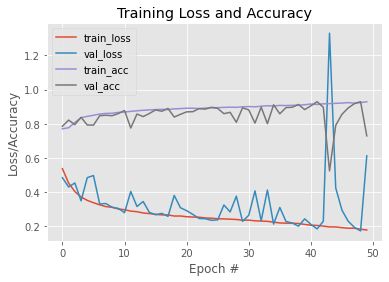

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 20:26:59 2020

@author: Administrator
"""
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
from keras.layers.pooling import GlobalAveragePooling2D
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath


def loadfile():
    # 读取数据和标签
    print("------开始读取数据------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set5')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
#        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
#            chanDim = 1
        model.add(Conv2D(64, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#        model.add(Dropout(0.25))

        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#        model.add(Dropout(0.25))
        
        model.add(Conv2D(512, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # FC层
        model.add(GlobalAveragePooling2D())#Flatten
        model.add(Dense(512))
        model.add(Activation("relu"))
#        model.add(BatchNormalization())
        model.add(Dropout(0.6))

        # softmax 分类
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.01
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型
#    # 训练网络模型
#    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
#        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
#        epochs=EPOCHS)
#    """
    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试
    print("------测试网络------")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/outputset5/cnn1_0.01.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset5/cnn1_0.01.h5')
    f = open('/content/drive/My Drive/outputset5/cnn.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()

cnn1 改进

------开始读取数据------
(17444, 64, 64, 3) (4362, 64, 64, 3) (17444, 2) (4362, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
------准备训练网络------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)           

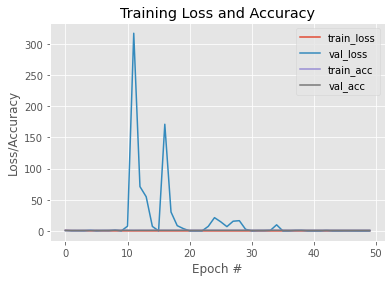

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 20:26:59 2020

@author: Administrator
"""
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
from keras.layers.pooling import GlobalAveragePooling2D
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def loadfile():
    # 读取数据和标签
    print("------开始读取数据------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set5')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        # CONV => RELU => POOL
        model.add(Conv2D(64, (3, 3), padding="same",
            input_shape=inputShape,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
#         (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
#         (CONV => RELU) * 3 => POOL
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(512, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # FC层
        model.add(Flatten())
        model.add(Dense(512,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.6))

        # softmax 分类
        model.add(Dense(classes,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("softmax"))

        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.1
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型
#    # 训练网络模型
#    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
#        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
#        epochs=EPOCHS)
#    """
    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试
    print("------测试网络------")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/outputset5/cnn1_change0.1.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset5/cnn1_change0.1.h5')
    f = open('/content/drive/My Drive/outputset5/cnn.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()

cnn2

------开始读取数据------
(17444, 64, 64, 3) (4362, 64, 64, 3) (17444, 2) (4362, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
------准备训练网络------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_28 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         non       0.78      1.00      0.88      3424
       smoke       0.00      0.00      0.00       938

    accuracy                           0.78      4362
   macro avg       0.39      0.50      0.44      4362
weighted avg       0.62      0.78      0.69      4362

------正在保存模型------


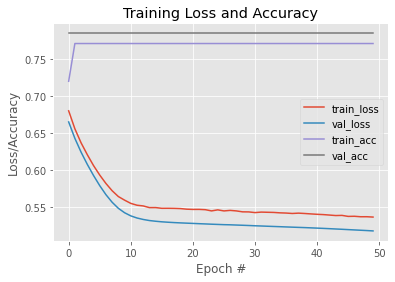

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 20:26:59 2020

@author: Administrator
"""
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
from keras.layers.pooling import GlobalAveragePooling2D
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def loadfile():
    # 读取数据和标签
    print("------开始读取数据------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set5')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
#        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
#            chanDim = 1
        model.add(Conv2D(64, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#        model.add(Dropout(0.25))

        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#        model.add(Dropout(0.25))
        model.add(Conv2D(512, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(512, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # FC层
        model.add(GlobalAveragePooling2D())#Flatten
        model.add(Dense(512))
        model.add(Activation("relu"))
#        model.add(BatchNormalization())
        model.add(Dropout(0.6))

        # softmax 分类
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.0001
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型
#    # 训练网络模型
#    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
#        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
#        epochs=EPOCHS)
#    """
    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试
    print("------测试网络------")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/outputset5/cnn2_0.0001.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset5/cnn2_0.0001.h5')
    f = open('/content/drive/My Drive/outputset5/cnn.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()

cnn2改进

------开始读取数据------
(17444, 64, 64, 3) (4362, 64, 64, 3) (17444, 2) (4362, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
------准备训练网络------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (

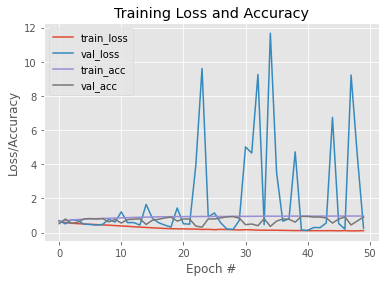

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 20:26:59 2020

@author: Administrator
"""
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
from keras.layers.pooling import GlobalAveragePooling2D
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def loadfile():
    # 读取数据和标签
    print("------开始读取数据------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set5')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        # CONV => RELU => POOL
        model.add(Conv2D(64, (3, 3), padding="same",
            input_shape=inputShape,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
#         (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#        model.add(Dropout(0.25))
#         (CONV => RELU) * 3 => POOL
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(512, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(512, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # FC层
        model.add(Flatten())
        model.add(Dense(512,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.6))

        # softmax 分类
        model.add(Dense(classes,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("softmax"))

        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.0001
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型
#    # 训练网络模型
#    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
#        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
#        epochs=EPOCHS)
#    """
    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试
    print("------测试网络------")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/outputset5/cnn2_change0.0001.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset5/cnn2_change0.0001.h5')
    f = open('/content/drive/My Drive/outputset5/cnn.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()

------开始读取数据------
(17444, 64, 64, 3) (4362, 64, 64, 3) (17444, 2) (4362, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
------准备训练网络------
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_32 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)          

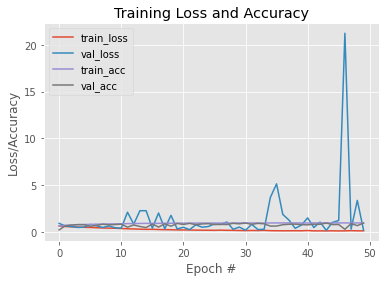

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 20:26:59 2020

@author: Administrator
"""
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
from keras.layers.pooling import GlobalAveragePooling2D
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def loadfile():
    # 读取数据和标签
    print("------开始读取数据------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set5')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        # CONV => RELU => POOL
        model.add(Conv2D(64, (3, 3), padding="same",
            input_shape=inputShape,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
#         (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#        model.add(Dropout(0.25))
#         (CONV => RELU) * 3 => POOL
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(512, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(512, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # FC层
        model.add(Flatten())
        model.add(Dense(512,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.6))

        # softmax 分类
        model.add(Dense(classes,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("softmax"))

        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.0001
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型
#    # 训练网络模型
#    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
#        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
#        epochs=EPOCHS)
#    """
    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试
    print("------测试网络------")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/outputset5/cnn2_change0.0001.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset5/cnn2_change0.0001.h5')
    f = open('/content/drive/My Drive/outputset5/cnn.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()

------开始读取数据------
(17444, 64, 64, 3) (4362, 64, 64, 3) (17444, 2) (4362, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
------准备训练网络------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_16 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)          

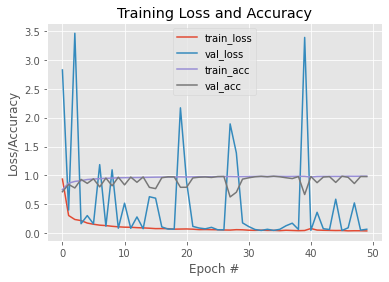

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 20:26:59 2020

@author: Administrator
"""
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
from keras.layers.pooling import GlobalAveragePooling2D
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def loadfile():
    # 读取数据和标签
    print("------开始读取数据------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set5')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        # CONV => RELU => POOL
        model.add(Conv2D(64, (3, 3), padding="same",
            input_shape=inputShape,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
#         (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#        model.add(Dropout(0.25))
#         (CONV => RELU) * 3 => POOL
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(512, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(512, (3, 3), padding="same",kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # FC层
        model.add(Flatten())
        model.add(Dense(512,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.6))

        # softmax 分类
        model.add(Dense(classes,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)))
        model.add(Activation("softmax"))

        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.1
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型
#    # 训练网络模型
#    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
#        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
#        epochs=EPOCHS)
#    """
    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试
    print("------测试网络------")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/outputset5/cnn2_change0.1.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset5/cnn2_change0.1.h5')
    f = open('/content/drive/My Drive/outputset5/cnn.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()

vgg迁移

------开始读取数据vgg16------
(17444, 64, 64, 3) (4362, 64, 64, 3) (17444, 2) (4362, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
__________________________________________________

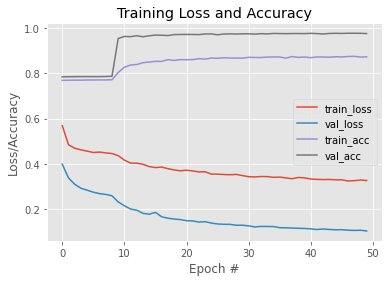

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 17 16:01:13 2020

@author: Administrator
"""

# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
#from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
from keras import optimizers
from keras import applications
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def loadfile():
    # 读取数据和标签
    print("------开始读取数据vgg16------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set5')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
#        model = Sequential()
        inputShape = (height, width, depth)
#        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
#            chanDim = 1
#        model.add(Conv2D(64, (3, 3), padding="same",
#            input_shape=inputShape))

        base_model = applications.VGG16(weights="imagenet", include_top=False,
                                        input_shape=inputShape)  # 预训练的VGG16网络，替换掉顶部网络
        print('base_model',base_model.summary())
        
        for layer in base_model.layers[:15]: layer.trainable = False  # 冻结预训练网络前15层
        
        top_model = Sequential()  # 自定义顶层网络
        top_model.add(Flatten(input_shape=base_model.output_shape[1:]))  # 将预训练网络展平
        top_model.add(Dense(2, activation='relu'))  # 全连接层，输入像素256
        top_model.add(Dropout(0.5))  # Dropout概率0.5
        top_model.add(Dense(classes, activation='softmax'))  # 输出层，二分类
        print('top_model',top_model.summary())
        model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.0001
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型

    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试

    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

    plt.savefig('/content/drive/My Drive/outputset5/vgg16-0.0001.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset5/vgg16-0.0001.h5')
    f = open('/content/drive/My Drive/outputset5/vgg16.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()

**残差迁移**

------开始读取数据------
(32853, 64, 64, 3) (8214, 64, 64, 3) (32853, 2) (8214, 2) LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
94773248/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
_____________________________________________________________________________________

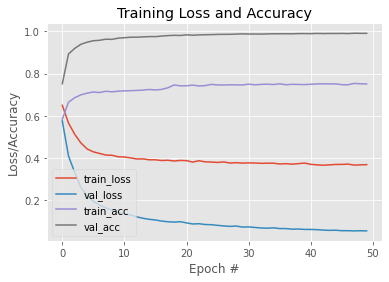

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 17 16:01:13 2020

@author: Administrator
"""

# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 18:06:20 2020

@author: Administrator
"""
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
#from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import keras
#import tensorflow as tf
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#import utils_paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
import pickle
import cv2
from keras import optimizers
from keras import applications
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
 
 
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)

def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue
 
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
 
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def loadfile():
    # 读取数据和标签
    print("------开始读取数据------")
    data = []
    labels = []
    # 拿到图像数据路径，方便后续读取
    imagePaths = sorted(list(list_images('/content/set11')))
    random.seed(42)
    random.shuffle(imagePaths)
    #print(imagePaths)
    # 遍历读取数据
    for imagePath in imagePaths:
        # 读取图像数据
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        # 读取标签
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    # 对图像数据做scale操作
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    # 数据集切分
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, random_state=42)
    #print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    # 转换标签为one-hot encoding格式
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY) #该放多针对多分类有效
    testY = lb.transform(testY)
    #
    trainY = keras.utils.to_categorical(trainY,2)
    testY = keras.utils.to_categorical(testY,2)
    return trainX, testX, trainY, testY,lb
class SimpleVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
#        model = Sequential()
        inputShape = (height, width, depth)
#        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
#            chanDim = 1
#        model.add(Conv2D(64, (3, 3), padding="same",
#            input_shape=inputShape))

        base_model = applications.ResNet50(weights="imagenet", include_top=False,
                                        input_shape=inputShape)  # 预训练的VGG16网络，替换掉顶部网络
        print('base_model',base_model.summary())
        
       # for layer in base_model.layers[:15]: layer.trainable = False  # 冻结预训练网络前15层
        
        top_model = Sequential()  # 自定义顶层网络
        top_model.add(Flatten(input_shape=base_model.output_shape[1:]))  # 将预训练网络展平
        top_model.add(Dense(2, activation='relu'))  # 全连接层，输入像素256
        top_model.add(Dropout(0.5))  # Dropout概率0.5
        top_model.add(Dense(classes, activation='softmax'))  # 输出层，二分类
        print('top_model',top_model.summary())
        model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
        return model
if __name__ == '__main__':
    trainX, testX, trainY, testY,lb=loadfile()
    print(trainX.shape,testX.shape,trainY.shape,testY.shape,lb)
#    np.save('Train-img_data',trainX)
#    np.save('Train-img_label',trainY)
#    np.save('Test-img_data',testX)
#    np.save('Test-img_label',testY)
#    print('ok')
#    trainX = np.load('Train-img_data.npy')
#    testX=np.load('Train-img_label.npy')
#    trainY=np.load('Test-img_data.npy')
#    testY=np.load('Test-img_label.npy')
#    print(testY)
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
## 建立卷积神经网络
    model = SimpleVGGNet.build(width=64, height=64, depth=3,classes=len(lb.classes_))
#    # 设置初始化超参数
    INIT_LR = 0.0001
    EPOCHS = 50
    BS = 32
   # 损失函数，编译模型
    print("------准备训练网络------")
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    model.summary()#显示模型

    H = model.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=32)
#    """

#    # 测试
    print("------测试网络------")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))
#    
#    # 绘制结果曲线
    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/outputset11/resnet0.0001.png')
    #
    # 保存模型
    print("------正在保存模型------")
    model.save('/content/drive/My Drive/outputset11/resnet0.0001.h5')
    f = open('/content/drive/My Drive/outputset1/resnet.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()